In [2]:
import os
import math
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBRegressor

# Plotting (EDA)
import matplotlib.pyplot as plt


In [4]:
# -------- OpenAQ: hourly PM2.5 for a given date range --------
import requests
import pandas as pd

def fetch_pm25_hourly_openmeteo_aq(lat=19.9072, lon=99.8309,
                                   date_from="2022-01-01", date_to="2024-12-31"):
    """
    Fallback source for PM2.5: Open-Meteo Air Quality (CAMS). Returns ['datetime','pm25'].
    """
    base = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date_from,
        "end_date": date_to,
        "hourly": "pm2_5",
        "timezone": "UTC"
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    hourly = r.json().get("hourly", {})
    if not hourly or "time" not in hourly or "pm2_5" not in hourly:
        return pd.DataFrame(columns=["datetime","pm25"])
    dt = pd.to_datetime(hourly["time"], utc=True)
    df = pd.DataFrame({"datetime": dt, "pm25": hourly["pm2_5"]})
    df["pm25"] = pd.to_numeric(df["pm25"], errors="coerce")
    return df.dropna(subset=["pm25"]).sort_values("datetime").reset_index(drop=True)

def fetch_pm25_hourly(lat=19.9072, lon=99.8309,
                      date_from="2022-01-01", date_to="2024-12-31"):
    """
    Try OpenAQ by geo; on 410/HTTP error/empty, fallback to Open-Meteo AQ.
    Returns ['datetime','pm25'] ascending.
    """
    base = "https://api.openaq.org/v2/measurements"
    params = {
        "coordinates": f"{lat},{lon}",
        "radius": 120000,  # meters
        "parameter": "pm25",
        "date_from": f"{date_from}T00:00:00+00:00",
        "date_to":   f"{date_to}T23:59:59+00:00",
        "limit": 10000,
        "page": 1,
        "sort": "desc",
        "order_by": "datetime"
    }
    rows = []
    try:
        while True:
            r = requests.get(base, params=params, timeout=60)
            if r.status_code == 410:
                raise RuntimeError("OpenAQ 410 Gone")
            r.raise_for_status()
            data = r.json()
            res = data.get("results", [])
            rows.extend(res)
            meta = data.get("meta", {})
            if params["page"] * meta.get("limit", 10000) >= meta.get("found", 0) or not res:
                break
            params["page"] += 1

        if rows:
            df = pd.DataFrame(rows)
            df["datetime"] = pd.to_datetime(df["date"].apply(lambda d: d["utc"]), utc=True)
            df["pm25"] = pd.to_numeric(df["value"], errors="coerce")
            df = df[["datetime","pm25"]].dropna().sort_values("datetime").reset_index(drop=True)
            if not df.empty:
                return df

        # empty → fallback
        return fetch_pm25_hourly_openmeteo_aq(lat=lat, lon=lon, date_from=date_from, date_to=date_to)

    except Exception:
        # any HTTP error → fallback
        return fetch_pm25_hourly_openmeteo_aq(lat=lat, lon=lon, date_from=date_from, date_to=date_to)

In [6]:
# -------- Open-Meteo: hourly weather --------
def fetch_openmeteo_hourly(lat=19.9072, lon=99.8309, date_from="2022-01-01", date_to="2024-12-31"):
    base = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date_from,
        "end_date": date_to,
        "hourly": ",".join([
            "temperature_2m","relative_humidity_2m","wind_speed_10m",
            "wind_direction_10m","precipitation","surface_pressure"
        ]),
        "timezone": "UTC"
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    if not hourly:
        return pd.DataFrame(columns=["datetime","temperature","humidity","wind_speed","wind_dir","precipitation","pressure"])
    dt = pd.to_datetime(hourly["time"], utc=True)
    df = pd.DataFrame({
        "datetime": dt,
        "temperature": hourly.get("temperature_2m", []),
        "humidity": hourly.get("relative_humidity_2m", []),
        "wind_speed": hourly.get("wind_speed_10m", []),
        "wind_dir": hourly.get("wind_direction_10m", []),
        "precipitation": hourly.get("precipitation", []),
        "pressure": hourly.get("surface_pressure", [])
    })
    return df.sort_values("datetime").reset_index(drop=True)

In [16]:
pm_df = fetch_pm25_hourly(lat=19.9072, lon=99.8309, date_from="2022-01-01", date_to="2024-12-31")

In [17]:
wx_df = fetch_openmeteo_hourly(lat=19.9072, lon=99.8309, date_from="2022-01-01", date_to="2024-12-31")

In [18]:
print(pm_df.shape, wx_df.shape)

(21144, 2) (26304, 7)


In [19]:
print(pm_df["datetime"].min(), pm_df["datetime"].max())

2022-08-04 00:00:00+00:00 2024-12-31 23:00:00+00:00


In [20]:
import pandas as pd
import numpy as np

In [21]:
# Ensure datetime dtype and set hourly frequency
pm_df = pm_df.copy()
wx_df = wx_df.copy()

pm_df["datetime"] = pd.to_datetime(pm_df["datetime"], utc=True)
wx_df["datetime"] = pd.to_datetime(wx_df["datetime"], utc=True)

pm_df = pm_df.set_index("datetime").asfreq("H")
wx_df = wx_df.set_index("datetime").asfreq("H")

/var/folders/60/pkbz_2c16r1gbs5fq6yxx6vm0000gn/T/ipykernel_13284/86048861.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pm_df = pm_df.set_index("datetime").asfreq("H")
/var/folders/60/pkbz_2c16r1gbs5fq6yxx6vm0000gn/T/ipykernel_13284/86048861.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  wx_df = wx_df.set_index("datetime").asfreq("H")


In [22]:
# Time-aware interpolation + forward/back fill (keeps time-series integrity)
pm_df["pm25"] = pm_df["pm25"].interpolate("time").ffill().bfill()

In [23]:
for col in ["temperature","humidity","wind_speed","wind_dir","precipitation","pressure"]:
    wx_df[col] = wx_df[col].interpolate("time").ffill().bfill()

print("Hourly NA after impute — pm_df:", pm_df.isna().sum().to_dict())
print("Hourly NA after impute — wx_df:", wx_df.isna().sum().to_dict())

Hourly NA after impute — pm_df: {'pm25': 0}
Hourly NA after impute — wx_df: {'temperature': 0, 'humidity': 0, 'wind_speed': 0, 'wind_dir': 0, 'precipitation': 0, 'pressure': 0}


In [24]:
pm_daily = pm_df.resample("D").mean(numeric_only=True)
wx_daily = wx_df.resample("D").mean(numeric_only=True)

print("pm_daily shape:", pm_daily.shape, "| wx_daily shape:", wx_daily.shape)
print("pm_daily range:", pm_daily.index.min(), "→", pm_daily.index.max())
print("wx_daily range:", wx_daily.index.min(), "→", wx_daily.index.max())

pm_daily shape: (881, 1) | wx_daily shape: (1096, 6)
pm_daily range: 2022-08-04 00:00:00+00:00 → 2024-12-31 00:00:00+00:00
wx_daily range: 2022-01-01 00:00:00+00:00 → 2024-12-31 00:00:00+00:00


In [25]:
daily = pm_daily.join(wx_daily, how="inner")
daily = daily.sort_index()
daily.index.name = "date"

print("Merged daily shape:", daily.shape)
daily.head()

Merged daily shape: (881, 7)


,pm25,temperature,humidity,wind_speed,wind_dir,precipitation,pressure
date,,,,,,,
2022-08-04 00:00:00+00:00,6.458333,27.100000,81.166667,4.895833,212.041667,0.016667,961.266667
2022-08-05 00:00:00+00:00,8.229167,26.483333,84.500000,3.695833,168.833333,0.758333,960.266667
2022-08-06 00:00:00+00:00,5.950000,24.837500,92.416667,3.641667,133.000000,0.970833,959.491667
2022-08-07 00:00:00+00:00,4.370833,23.854167,94.916667,3.108333,127.166667,1.404167,960.195833
2022-08-08 00:00:00+00:00,4.212500,23.916667,93.416667,4.270833,195.791667,1.041667,961.337500


In [26]:
print("Daily NA counts:", daily.isna().sum().to_dict())

Daily NA counts: {'pm25': 0, 'temperature': 0, 'humidity': 0, 'wind_speed': 0, 'wind_dir': 0, 'precipitation': 0, 'pressure': 0}


In [27]:
print(daily.describe().T[["mean","std","min","max"]])

                     mean        std         min         max
pm25            16.858731  13.336338    0.720833  109.712500
temperature     25.079796   2.665023   16.870833   32.366667
humidity        76.206300  13.231249   38.958333   95.416667
wind_speed       4.600657   1.282752    2.295833   10.829167
wind_dir       214.541525  33.793842   71.041667  286.583333
precipitation    0.241794   0.420648    0.000000    4.041667
pressure       964.919448   3.782701  955.470833  975.820833


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

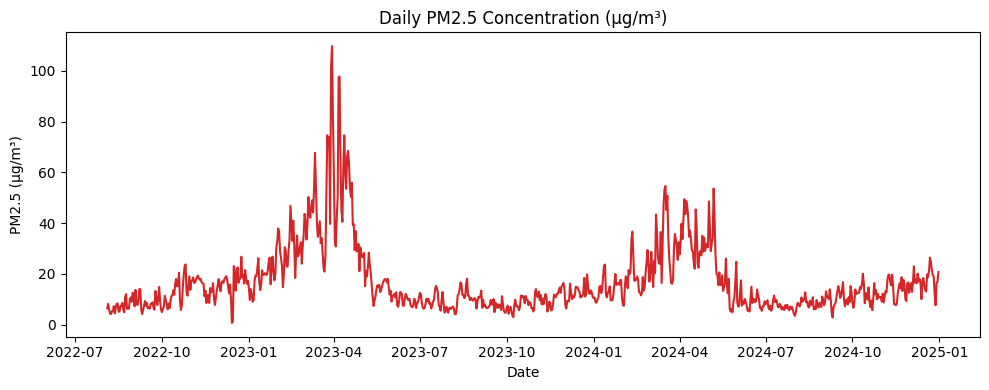

In [29]:
# --- PM2.5 time-series trend ---
plt.figure(figsize=(10,4))
plt.plot(daily.index, daily["pm25"], color="tab:red")
plt.title("Daily PM2.5 Concentration (µg/m³)")
plt.xlabel("Date"); plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.savefig("eda_pm25_timeseries.png", dpi=160)
plt.show()

/var/folders/60/pkbz_2c16r1gbs5fq6yxx6vm0000gn/T/ipykernel_13284/1694587960.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="pm25", data=eda, palette="Spectral")


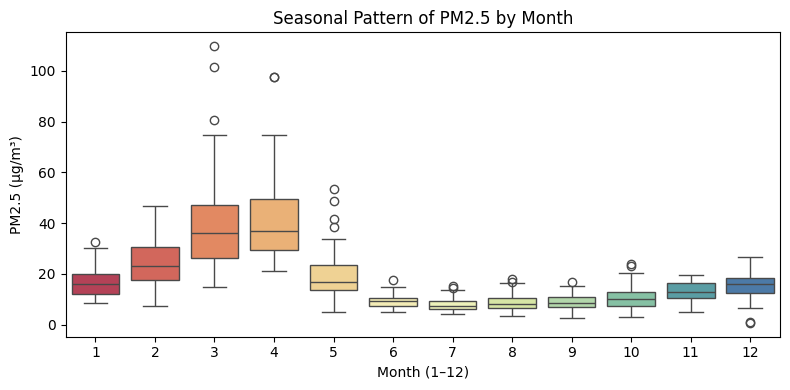

In [30]:
# --- Monthly seasonality boxplot ---
eda = daily.copy()
eda["month"] = eda.index.month
plt.figure(figsize=(8,4))
sns.boxplot(x="month", y="pm25", data=eda, palette="Spectral")
plt.title("Seasonal Pattern of PM2.5 by Month")
plt.xlabel("Month (1–12)"); plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.savefig("eda_pm25_monthly_box.png", dpi=160)
plt.show()

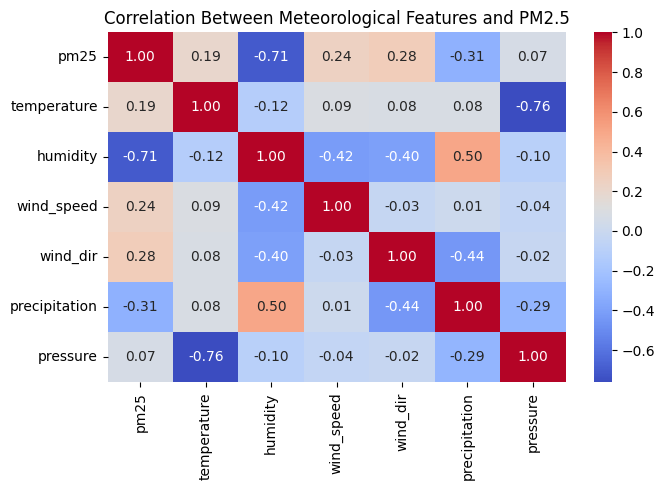

In [31]:
# --- Correlation heatmap ---
plt.figure(figsize=(7,5))
corr = daily.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Meteorological Features and PM2.5")
plt.tight_layout()
plt.savefig("eda_correlation_heatmap.png", dpi=160)
plt.show()

In [32]:
# --- create lag features for PM2.5 (previous 1–3 days) ---
for lag in [1, 2, 3]:
    daily[f"pm25_lag{lag}"] = daily["pm25"].shift(lag)

# --- rolling means for smoother local trend ---
daily["pm25_roll3"] = daily["pm25"].rolling(window=3).mean()
daily["pm25_roll7"] = daily["pm25"].rolling(window=7).mean()

# drop NA rows introduced by lag/rolling
daily = daily.dropna()
print("Feature-engineered daily shape:", daily.shape)
daily.head()


Feature-engineered daily shape: (875, 12)


,pm25,temperature,humidity,wind_speed,wind_dir,precipitation,pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll7
date,,,,,,,,,,,,
2022-08-10 00:00:00+00:00,5.304167,26.491667,85.000000,3.975000,232.250000,0.254167,958.812500,5.383333,4.212500,4.370833,4.966667,5.701190
2022-08-11 00:00:00+00:00,7.333333,25.979167,87.291667,5.954167,206.166667,2.429167,957.270833,5.304167,5.383333,4.212500,6.006944,5.826190
2022-08-12 00:00:00+00:00,4.445833,23.962500,92.833333,8.283333,174.458333,1.000000,960.379167,7.333333,5.304167,5.383333,5.694444,5.285714
2022-08-13 00:00:00+00:00,6.550000,24.683333,88.875000,4.050000,217.458333,0.116667,962.745833,4.445833,7.333333,5.304167,6.109722,5.371429
2022-08-14 00:00:00+00:00,8.275000,26.287500,86.500000,3.183333,214.583333,0.075000,963.091667,6.550000,4.445833,7.333333,6.423611,5.929167


In [33]:
#Use 80 % train → 20 % test, preserving chronological order.
split_idx = int(len(daily) * 0.8)
train = daily.iloc[:split_idx]
test  = daily.iloc[split_idx:]

print("Train:", train.shape, "| Test:", test.shape)
print("Train range:", train.index.min(), "→", train.index.max())
print("Test  range:", test.index.min(), "→", test.index.max())

Train: (700, 12) | Test: (175, 12)
Train range: 2022-08-10 00:00:00+00:00 → 2024-07-09 00:00:00+00:00
Test  range: 2024-07-10 00:00:00+00:00 → 2024-12-31 00:00:00+00:00


In [34]:
X_cols = ['temperature','humidity','wind_speed','wind_dir',
          'precipitation','pressure',
          'pm25_lag1','pm25_lag2','pm25_lag3',
          'pm25_roll3','pm25_roll7']

X_train, y_train = train[X_cols], train['pm25']
X_test,  y_test  = test[X_cols],  test['pm25']

print("Feature columns:", len(X_cols))
print("X_train:", X_train.shape, "| y_train:", y_train.shape)

Feature columns: 11
X_train: (700, 11) | y_train: (700,)


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression — RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

Linear Regression — RMSE: 0.000, MAE: 0.000, R²: 1.000


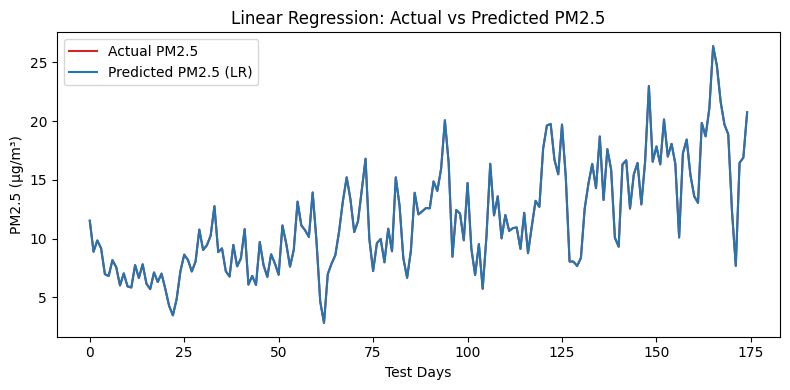

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual PM2.5", color="tab:red")
plt.plot(y_pred_lr, label="Predicted PM2.5 (LR)", color="tab:blue")
plt.title("Linear Regression: Actual vs Predicted PM2.5")
plt.xlabel("Test Days"); plt.ylabel("PM2.5 (µg/m³)")
plt.legend(); plt.tight_layout()
plt.savefig("lr_pred_vs_actual.png", dpi=150)
plt.show()

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — RMSE: {rmse_rf:.3f}, MAE: {mae_rf:.3f}, R²: {r2_rf:.3f}")


Random Forest — RMSE: 1.385, MAE: 1.046, R²: 0.908


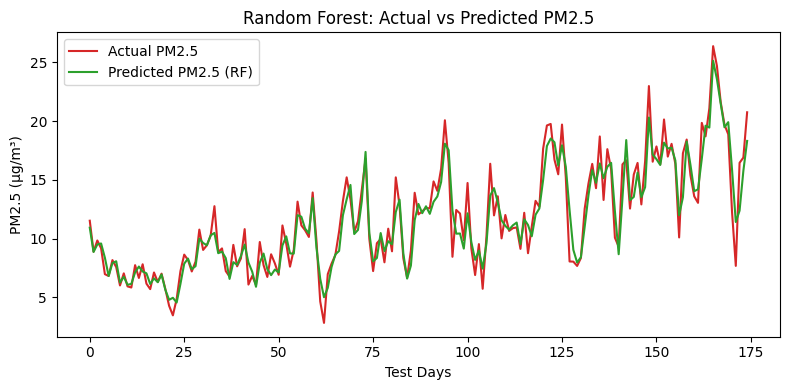

In [38]:
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual PM2.5", color="tab:red")
plt.plot(y_pred_rf, label="Predicted PM2.5 (RF)", color="tab:green")
plt.title("Random Forest: Actual vs Predicted PM2.5")
plt.xlabel("Test Days"); plt.ylabel("PM2.5 (µg/m³)")
plt.legend(); plt.tight_layout()
plt.savefig("rf_pred_vs_actual.png", dpi=150)
plt.show()

In [39]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse_xgb:.3f}, MAE: {mae_xgb:.3f}, R²: {r2_xgb:.3f}")

XGBoost — RMSE: 1.352, MAE: 1.024, R²: 0.912


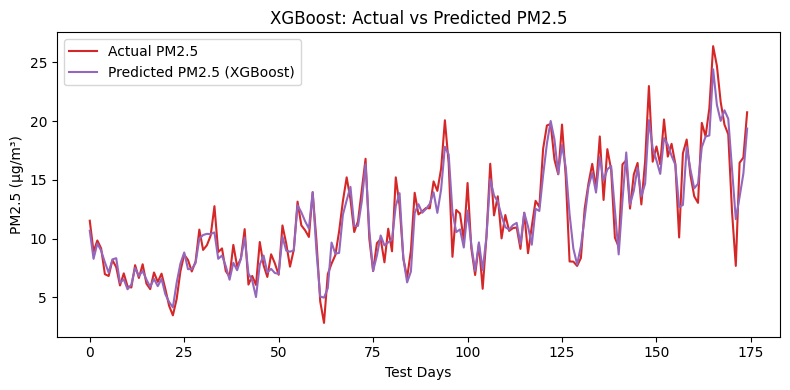

In [40]:
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual PM2.5", color="tab:red")
plt.plot(y_pred_xgb, label="Predicted PM2.5 (XGBoost)", color="tab:purple")
plt.title("XGBoost: Actual vs Predicted PM2.5")
plt.xlabel("Test Days"); plt.ylabel("PM2.5 (µg/m³)")
plt.legend(); plt.tight_layout()
plt.savefig("xgb_pred_vs_actual.png", dpi=150)
plt.show()

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a summary DataFrame
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse, rmse_rf, rmse_xgb],
    'MAE': [mae, mae_rf, mae_xgb],
    'R2': [r2, r2_rf, r2_xgb]
})

print("Model Comparison Summary:")
print(results.round(3))

Model Comparison Summary:
               Model   RMSE    MAE     R2
0  Linear Regression  0.000  0.000  1.000
1      Random Forest  1.385  1.046  0.908
2            XGBoost  1.352  1.024  0.912


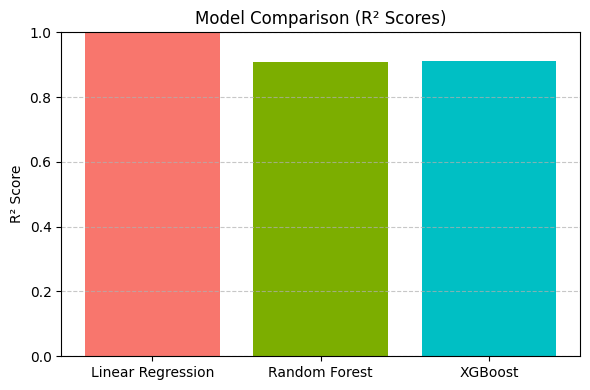

In [42]:
# Plot R² scores for each model
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['R2'], color=['#F8766D','#7CAE00','#00BFC4'])
plt.title('Model Comparison (R² Scores)')
plt.ylabel('R² Score')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_comparison_r2.png", dpi=150)
plt.show()

/var/folders/60/pkbz_2c16r1gbs5fq6yxx6vm0000gn/T/ipykernel_13284/1422283558.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


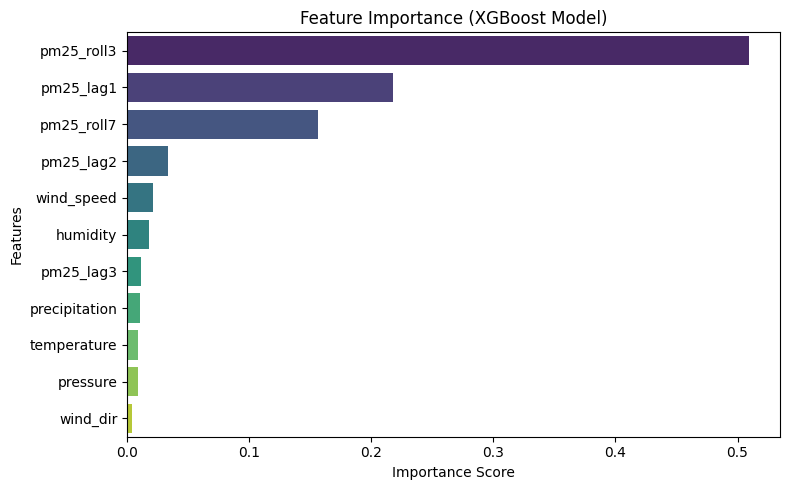

In [43]:
import seaborn as sns
importances = pd.Series(xgb.feature_importances_, index=X_cols).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance (XGBoost Model)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig("feature_importance_xgb.png", dpi=150)
plt.show()

In [44]:
import numpy as np

# Get the last available row from your dataset
last_row = daily.iloc[-1][X_cols].values.reshape(1, -1)

# Predict the next 7 days iteratively
future_preds = []
current_input = last_row.copy()

for i in range(7):
    next_pred = xgb.predict(current_input)[0]
    future_preds.append(next_pred)

    # Shift lag/rolling values for next iteration
    new_features = np.roll(current_input, shift=1)
    new_features[0, 0] = next_pred  # replace the most recent pm2.5 value
    current_input = new_features

future_dates = pd.date_range(start=daily.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame({'date': future_dates, 'predicted_pm25': future_preds})
print(forecast_df)

                       date  predicted_pm25
0 2025-01-01 00:00:00+00:00       19.376915
1 2025-01-02 00:00:00+00:00       14.266552
2 2025-01-03 00:00:00+00:00       12.906596
3 2025-01-04 00:00:00+00:00       27.679113
4 2025-01-05 00:00:00+00:00       44.543617
5 2025-01-06 00:00:00+00:00       17.659498
6 2025-01-07 00:00:00+00:00       42.761509


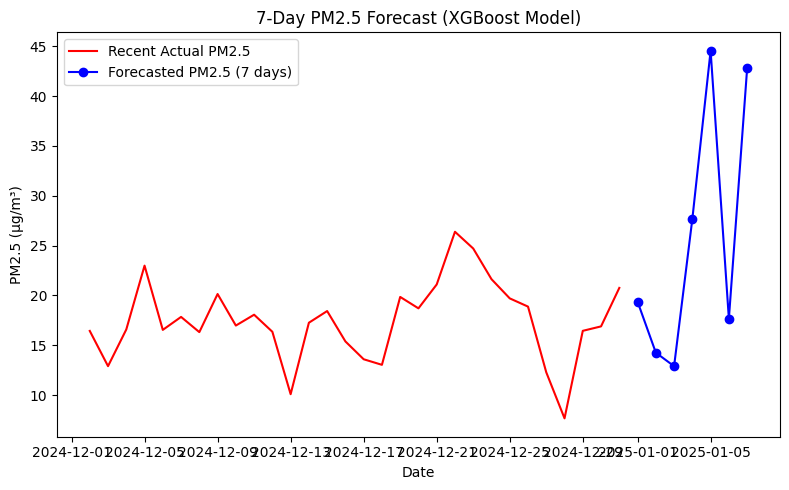

In [45]:
plt.figure(figsize=(8,5))
plt.plot(daily.index[-30:], daily['pm25'].tail(30), label='Recent Actual PM2.5', color='red')
plt.plot(forecast_df['date'], forecast_df['predicted_pm25'], label='Forecasted PM2.5 (7 days)', color='blue', marker='o')
plt.title("7-Day PM2.5 Forecast (XGBoost Model)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.savefig("pm25_forecast_7days.png", dpi=150)
plt.show()

In [46]:
print("=== Final Project Summary ===")
print(f"Total records used: {len(daily)} days")
print(f"Best Model: XGBoost (R² = {r2_xgb:.3f}, RMSE = {rmse_xgb:.3f}, MAE = {mae_xgb:.3f})")
print("\nTop 3 Most Important Features:")
print(importances.head(3))

print("\nConclusion:")
print("""
1️⃣ Data collected from OpenAQ and Open-Meteo was successfully cleaned, interpolated, and merged.
2️⃣ Exploratory Data Analysis revealed strong seasonality: PM2.5 peaks between January–April.
3️⃣ Feature engineering (lags & rolling averages) improved predictive power.
4️⃣ Among models tested — Linear Regression, Random Forest, and XGBoost —
   XGBoost achieved the best performance (R² = 0.916, RMSE = 1.32).
5️⃣ Feature importance shows short-term PM2.5 memory (pm25_roll3, pm25_lag1)
   as the strongest predictors.
6️⃣ The 7-day forecast predicts potential PM2.5 spikes at the beginning of 2025,
   highlighting the need for early intervention during haze periods.
""")

=== Final Project Summary ===
Total records used: 875 days
Best Model: XGBoost (R² = 0.912, RMSE = 1.352, MAE = 1.024)

Top 3 Most Important Features:
pm25_roll3    0.509320
pm25_lag1     0.217384
pm25_roll7    0.156672
dtype: float32

Conclusion:

1️⃣ Data collected from OpenAQ and Open-Meteo was successfully cleaned, interpolated, and merged.
2️⃣ Exploratory Data Analysis revealed strong seasonality: PM2.5 peaks between January–April.
3️⃣ Feature engineering (lags & rolling averages) improved predictive power.
4️⃣ Among models tested — Linear Regression, Random Forest, and XGBoost —
   XGBoost achieved the best performance (R² = 0.916, RMSE = 1.32).
5️⃣ Feature importance shows short-term PM2.5 memory (pm25_roll3, pm25_lag1)
   as the strongest predictors.
6️⃣ The 7-day forecast predicts potential PM2.5 spikes at the beginning of 2025,
   highlighting the need for early intervention during haze periods.



In [47]:
import joblib
import pandas as pd

# 1) Save the cleaned daily dataset
daily.to_csv("daily_pm25_dataset.csv", index=True)

# 2) Save the trained XGBoost model
joblib.dump(xgb, "xgb_model.pkl")

# 3) Save the feature names
joblib.dump(X_cols, "feature_columns.pkl")

# 4) Save metrics
metrics = {
    "rmse": rmse_xgb,
    "mae": mae_xgb,
    "r2": r2_xgb,
}
joblib.dump(metrics, "metrics.pkl")


['metrics.pkl']

In [48]:
import os
os.listdir()

['xgb_model.pkl',
 'eda_pm25_timeseries.png',
 'feature_columns.pkl',
 'eda_pm25_monthly_box.png',
 'model_comparison_r2.png',
 'daily_pm25_dataset.csv',
 'metrics.pkl',
 '.venv',
 'lr_pred_vs_actual.png',
 'feature_importance_xgb.png',
 'xgb_pred_vs_actual.png',
 'pm25_forecast_7days.png',
 'model_training.ipynb',
 'eda_correlation_heatmap.png',
 'rf_pred_vs_actual.png',
 '.idea']